In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [5]:
## Step 1: Extract Files
import zipfile
test_path = '/kaggle/input/dogs-vs-cats/test1.zip'
train_path = '/kaggle/input/dogs-vs-cats/train.zip'
extract_path = '/kaggle/working/extracted'
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    
with zipfile.ZipFile(train_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    
# Check whats inside the folder. Folder contains jpg files of cats and dogs.
# for dirname, _, filenames in os.walk('/kaggle/working'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

/kaggle/working/extracted/train/cat.7217.jpg


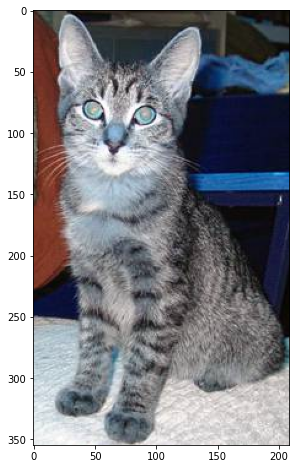

In [6]:
## Step 2: Visualize some images from the train set.
import cv2
import matplotlib.pyplot as plt

num_images = 1
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/extracted/train'):
    for filename in filenames:
        if count < num_images:
            image_path = os.path.join(dirname, filename)
            print(image_path)
            image_read = cv2.imread(image_path)
            plt.figure(figsize=(8,8))
            plt.imshow(image_read)
            count += 1


In [7]:
## Step 3: Create a dataloader for Pytorch

# Label 0 = Cat, 1 = dog
# train_dir = '/kaggle/working/extracted/train'
# print(os.listdir(train_dir))

from torch.utils.data import Dataset, DataLoader

class CatDogDataset(Dataset):

    def __init__(self, train_dir, img_list, transform = None):
        
        self.train_dir = train_dir
        self.transform = transform
        self.images = img_list
        

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.train_dir, self.images[index])
        label = self.images[index].split(".")[0]

        label = 0 if label == 'cat' else 1
        img = cv2.imread(image_path)
        if self.transform:
            img = self.transform(img)
        img = img.numpy()
        return img.astype('float32'), label

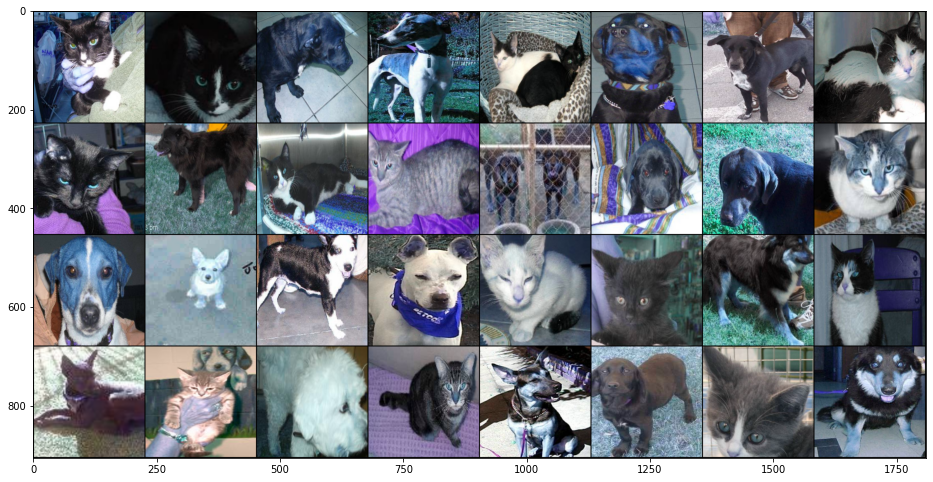

In [8]:
## Step 4: Create training dataset
from torchvision import transforms
import torchvision

train_dir = '/kaggle/working/extracted/train'
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip()
])
img_list = os.listdir(train_dir)
train_dataset = CatDogDataset(train_dir, img_list, transform = data_transform)

# Visualize created dataset
dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=2)

samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,32))
grid_imgs = torchvision.utils.make_grid(samples[:32])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [9]:
## Step 5: Define Deep Learning model
# First model will be a model from scratch, 2nd model will use transfer learning to utilize pretrained Resnet model

import torch
import torch.nn as nn

## First model
class scratch_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=100, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(100, 200, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(200, 400, 3, stride=1, padding=0)
        self.mpool = nn.MaxPool2d(kernel_size=3)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(19600,1024)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,2)
        self.classifier = nn.Softmax(dim=1)
        
    def forward(self,x):
        x = self.mpool( self.relu(self.conv1(x)) )
        x = self.mpool( self.relu(self.conv2(x)) )
        x = self.mpool( self.relu(self.conv3(x)) )
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.classifier(x)
        return x

# Test code
# net = scratch_nn()
# print(net)
# y_pred = net.forward(samples)
# print(samples.shape)
# print(y_pred)
# print(y_pred.shape)

In [10]:
## Step 6: Define train_step and predict functions

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

def train_step(model, optimizer, criterion, train_loader):
    model.train()
    avg_loss = []
    for x,y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x=x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss.append(loss.item())
    return sum(avg_loss)/len(avg_loss)

def predict(model, test_loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    with torch.no_grad():
        for x,y in tqdm(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = model(x=x)
            y_pred = torch.argmax(pred, dim=1)
#             print(y)
#             print(len(y))
#             print(y_pred)
#             print(len(y_pred))
            total_preds = torch.cat((total_preds, y_pred.cpu()), 0)
            total_labels = torch.cat((total_labels, y.cpu()), 0)
    return total_labels.numpy().flatten(),total_preds.numpy().flatten()
    

cuda


In [11]:
## Step 7: Define main train function

from sklearn.metrics import accuracy_score
import copy

def train(model, dataset, val_dataset):
    num_epoch = 25
    # lr and weight_decay are hyperparameters. For now setting their values manually
    lr = 0.001
    weight_dec = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_dec)
    criterion = nn.CrossEntropyLoss()
    batch_size = 32
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    max_accuracy = 0
    model = model.to(device)
    model_file_name = "working\scratch_best_model.model"
    for epoch in range(1, num_epoch + 1):
        train_loss = train_step(model, optimizer, criterion, dataloader)
        if epoch % 100 == 0:
            print(f"Loss at epoch {epoch} is {train_loss}")
        G,P = predict(model, val_dataloader)
        accuracy = accuracy_score(G, P)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), model_file_name)
            print("saving best model with accuracy: ", accuracy)
    return best_model
    
    

In [ ]:
## Step 8: Create train and validation dataset and train model

from sklearn.metrics import classification_report

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip()
])
train_dir = '/kaggle/working/extracted/train'
train_img_list = os.listdir(train_dir)[1:20000]
val_img_list = os.listdir(train_dir)[20000:25000]
train_dataset = CatDogDataset(train_dir, train_img_list, transform = data_transform)
val_dataset = CatDogDataset(train_dir, val_img_list, transform = data_transform)

model = scratch_nn()

best_model = train(model=model, dataset=train_dataset, val_dataset=val_dataset)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)
G,P = predict(model, val_dataloader)
print(classification_report(G,P))


100%|██████████| 157/157 [00:20<00:00,  7.66it/s]


saving best model with accuracy:  0.5072


 94%|█████████▍| 589/625 [01:29<00:05,  6.64it/s]